In [1]:
# import libraries
import pandas as pd
import numpy as np
import ast
import json
import warnings
import requests
import urllib.request
from random import sample
from sklearn.metrics.pairwise import cosine_similarity
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras import Model, regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers 
# import cv2
# import Image


warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
images = pd.read_csv("listing_image.csv")
images.head(5)

,listing_id,listing_image_order,created,public_url
0,3,0,2015-10-22,https://cdn.rexhomes.com/listing/7a51c98bb10b4...
1,3,19,2015-10-22,https://cdn.rexhomes.com/listing/7a51c98bb10b4...
2,3,20,2017-04-11,https://cdn.rexhomes.com/listing/7a51c98bb10b4...
3,24,0,2015-10-22,https://cdn.rexhomes.com/listing/2b2ccefd58184...
4,24,3,2015-10-22,https://cdn.rexhomes.com/listing/2b2ccefd58184...


## join listing with mls to get home_style feature

In [3]:
listing = pd.read_csv("listing.csv")
listing.head()

,id,guid,created,updated,address_id,bedrooms,coming_soon_date,competitive_bidding_expiration_date,county,description,...,signed_date,sold_date,status,stories,timezone_id,total_baths,total_baths_calculated,total_rooms,year_built,geom
0,3,7a51c98bb10b4f04a3ef19e6ca6605a1,2015-03-30 21:20:17,2018-02-21 21:14:36,4,4.0,NaN,2016-05-12 10:00:44,Ventura,"Single story, 4 bedrooms, 3 baths, plus bonus ...",...,NaN,2015-09-11,SOLD,1.0,America/Los_Angeles,3.0,NaN,8.0,1963.0,NaN
1,22,63390d5e80d94d62875224a90d599f2f,2015-04-22 19:34:25,2015-04-22 19:34:26,20,3.0,NaN,NaN,Los Angeles,NaN,...,NaN,NaN,PREVIEW,0.0,America/Los_Angeles,2.0,2.0,0.0,1947.0,NaN
2,24,2b2ccefd58184bccb82a7af010ac6a58,2015-04-22 21:17:21,2018-02-21 21:29:29,21,12.0,NaN,2016-05-12 10:00:22,Los Angeles,Oceanfront estate features three homes and a p...,...,NaN,2015-03-31,SOLD,1.0,America/Los_Angeles,12.0,2.0,33.0,2015.0,NaN
3,26,890de2d248d34c4f832ad8294983f6dd,2015-04-24 19:08:36,2015-04-24 19:08:37,23,3.0,NaN,NaN,Orange,NaN,...,NaN,NaN,PREVIEW,1.0,America/Los_Angeles,2.0,2.0,5.0,1985.0,NaN
4,28,f3923ae4cae248b5b236441a0ec65a05,2015-04-30 20:39:13,2015-05-04 19:18:23,24,3.0,NaN,NaN,Ventura,Custom Property Description Here,...,NaN,NaN,CLAIMED,1.0,America/Los_Angeles,2.0,2.0,6.0,1970.0,NaN


In [145]:
addr = pd.read_csv("address.csv")
addr.head()

,id,guid,address_line,city,state,postal_code,created,updated
0,360,75bb16cdde1e40d3bacfcde645ffa1b2,1245 Cordova St Apt 301,Pasadena,CA,91106,2016-05-21 15:30:03,2016-05-21 15:30:03
1,361,27972de492f4441fbc62a55908b9ba79,216 S Madison Ave Apt 205,Pasadena,CA,91101,2016-05-21 16:44:31,2016-05-21 16:44:31
2,362,842b64bc81f4421888274b55cb15228c,2355 Grand Ave,Ventura,CA,93003,2016-05-22 20:33:15,2016-05-22 20:33:15
3,363,5dd958430d54481c98863d32337e8c6c,6034 Capistrano Ave,Woodland Hills,CA,91367,2016-05-22 23:50:42,2016-05-22 23:50:42
4,364,a74433fdd2b3436fb12a504e5e3e3204,15206 Hartsook St,Sherman Oaks,CA,91403,2016-05-23 02:23:13,2016-05-23 02:23:13


In [146]:
listings = listing.merge(addr, left_on='address_id', right_on='id', how='inner')
listings.shape

(128998, 53)

In [147]:
rex_listing_cols = ['id_x','rex_url','price','bedrooms','total_baths', 'total_baths_calculated', 'total_rooms',
       'county','address_line', 'city', 'state','postal_code',
       'description', 'full_baths', 'half_baths', 'hoa_fee', 'land_square_footage',
       'living_square_feet', 'stories','year_built','latitude', 'longitude',
       'marketing_budget', 'neighborhood', 'property_type',
       'school_district_id','school_district_name']

In [148]:
listings = listings[rex_listing_cols]

In [149]:
listings.shape

(128998, 27)

In [150]:
listings.drop_duplicates('rex_url',inplace=True)

In [151]:
listings['address_line'] = listings['address_line'].str.lower()

In [152]:
listings_split = listings.copy()
listings_split[['street_address','apt_num']] = listings['address_line'].str.split(' apt|, apartment| unit| #', 1, expand=True)
listings_split.head()

,id_x,rex_url,price,bedrooms,total_baths,total_baths_calculated,total_rooms,county,address_line,city,...,year_built,latitude,longitude,marketing_budget,neighborhood,property_type,school_district_id,school_district_name,street_address,apt_num
0,3,1335-calle-pecos,980000.0,4.0,3.0,NaN,8.0,Ventura,1335 calle pecos,THOUSAND OAKS,...,1963.0,34.198950,-118.899352,LOW,NaN,SINGLE,NaN,NaN,1335 calle pecos,None
1,22,3848-spad-pl,NaN,3.0,2.0,2.0,0.0,Los Angeles,3848 spad pl,CULVER CITY,...,1947.0,34.015585,-118.409200,LOW,NaN,SINGLE,NaN,NaN,3848 spad pl,None
2,24,rex1-pacific-coast-hwy,44000000.0,12.0,12.0,2.0,33.0,Los Angeles,pacific coast hwy,MALIBU,...,2015.0,34.023865,-118.787080,LOW,NaN,SINGLE,NaN,NaN,pacific coast hwy,None
3,26,2934-hierro,NaN,3.0,2.0,2.0,5.0,Orange,2934 hierro,SAN CLEMENTE,...,1985.0,33.472814,-117.632560,LOW,NaN,SINGLE,NaN,NaN,2934 hierro,None
4,28,455-san-vincente-cir,NaN,3.0,2.0,2.0,6.0,Ventura,455 san vincente cir,NEWBURY PARK,...,1970.0,34.183448,-118.954360,LOW,NaN,SINGLE,NaN,NaN,455 san vincente cir,None


In [153]:
# mls data
MLS = pd.read_csv("join_house_market_to_first_american_06037.csv")
MLS.head()

,Unnamed: 0,cc_list_id,original_list_date,original_list_price,current_list_price,sale_price,sale_date,current_status,number_of_pricechanges,days_on_market,...,below_grade_bed_count,below_grade_sqft,current_use,fencing_description,frontage_length,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description
0,0,20236585.0,2019-11-15,NaN,384000.0,NaN,NaN,Withdrawn,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,20239491.0,2020-06-29,NaN,325000.0,325000.0,2020-08-21,Sale,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,59276131.0,2019-11-15,NaN,565000.0,565000.0,2020-01-24,Sale,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,65241117.0,2020-02-26,NaN,NaN,NaN,NaN,Active,NaN,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20931795.0,2019-11-04,NaN,565000.0,NaN,NaN,Active,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
MLS_cols = ['hoa_fee_amount','match_street_address','address', 'city', 'zipcode', 'latitude', 'longitude', 'sqft', 'state',
       'lot_sqft', 'year_built', 'image_urls','garage_spaces', 'garage_type', 'pool_spa_types',
       'view_description', 'porch_or_patio', 'laundry_features',
       'bedrooms', 'full_baths', 'half_baths',
       'tax_amount','number_of_units', 'parking_features',
       'heating', 'cooling', 'public_listing_comments',
       'water_source', 'property_type', 'current_list_price',
       'home_style', 'has_central_air', 'has_jacuzzi',
       'has_pool', 'has_solar', 'has_garage', 'garage_type_enum',
       'cooling_enum', 'fencing_description','property_condition', 'property_quality',
       'senior_community_indicator', 'zoning_code', 'zoning_description']

In [155]:
MLS = MLS[MLS_cols]

In [156]:
MLS.drop_duplicates('match_street_address',inplace=True)

In [157]:
# split mls address
MLS['match_street_address'] = MLS['match_street_address'].str.lower()

MLS_split = MLS.copy()
MLS_split[['street_address','apt_num']] = MLS['match_street_address'].str.split(' apt|, apartment| unit| #', 1, expand=True)
MLS_split.head()

,hoa_fee_amount,match_street_address,address,city,zipcode,latitude,longitude,sqft,state,lot_sqft,...,garage_type_enum,cooling_enum,fencing_description,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description,street_address,apt_num
0,NaN,4628 vitrina ln,4628 Vitrina Ln,Palmdale,93551,34.620360,-118.214069,NaN,CA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4628 vitrina ln,None
1,NaN,39062 dianron rd,39062 Dianron Rd,Palmdale,93551,34.592879,-118.155813,1400.0,CA,6969.0,...,NaN,central,NaN,NaN,NaN,NaN,NaN,NaN,39062 dianron rd,None
2,NaN,39943 pampas st,39943 Pampas St,Palmdale,93551,34.607212,-118.196368,NaN,CA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39943 pampas st,None
3,100.0,41019 woodshire dr,41019 Woodshire Dr,Palmdale,93551,34.627371,-118.222015,4933.0,CA,20087.0,...,NaN,central,NaN,NaN,NaN,NaN,NaN,NaN,41019 woodshire dr,None
4,NaN,6601 holmes ave,6601 Holmes Ave,Los Angeles,90001,33.979494,-118.241427,NaN,CA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6601 holmes ave,None


In [158]:
# merge listing with mls
print("Origin data: ", listings_split.shape, MLS_split.shape)
merge_df = listings_split.merge(MLS_split, left_on=['street_address','apt_num'], right_on=["street_address",'apt_num'], how='inner')
merge_df.shape

Origin data:  (128998, 29) (376188, 46)


(6000, 73)

In [159]:
merge_df.head()

,id_x,rex_url,price,bedrooms_x,total_baths,total_baths_calculated,total_rooms,county,address_line,city_x,...,has_solar,has_garage,garage_type_enum,cooling_enum,fencing_description,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description
0,24,rex1-pacific-coast-hwy,44000000.0,12.0,12.0,2.0,33.0,Los Angeles,pacific coast hwy,MALIBU,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73,4080-glencoe-ave-unit-316,NaN,1.0,2.0,2.0,0.0,Los Angeles,4080 glencoe ave unit 316,Marina Del Rey,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74,175-sequoia-dr,943900.0,3.0,2.0,2.0,7.0,Los Angeles,175 sequoia dr,Pasadena,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,79,6560-3rd-ave,NaN,2.0,1.0,1.0,5.0,Los Angeles,6560 3rd ave,Los Angeles,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,81,1258-barry-ave-unit-5,NaN,3.0,2.0,2.0,0.0,Los Angeles,1258 barry ave apt 5,Los Angeles,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
style_df = merge_df[['id_x', 'home_style']]
style_df.head(5)

,id_x,home_style
0,24,NaN
1,73,Other
2,74,NaN
3,79,Spanish
4,81,Other


In [161]:
style_removed_na = style_df.dropna()
style_removed_na.head()

,id_x,home_style
1,73,Other
3,79,Spanish
4,81,Other
6,95,Other
9,121,Other


In [162]:
# merge listing_images with style
final = images.merge(style_removed_na,left_on="listing_id",right_on="id_x",how="inner")
final.head()

,listing_id,listing_image_order,created,public_url,id_x,home_style
0,311,0,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean
1,311,1,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean
2,311,2,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean
3,311,3,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean
4,311,5,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean


In [163]:
final.shape

(2740, 6)

## Prepare Final Dataset With Images

train on listing_images with home_style labeled

In [164]:
# download images from url

test_image_urls = list(final['public_url'])
i = 0
for test_image_url in test_image_urls:
    urllib.request.urlretrieve(test_image_url, "image_photos/"+str(i)+'.jpg')
    i += 1

In [ ]:
"""
train-test split
predict style of other images originally not matched
get second last layer feature of the images
"""

In [165]:
final.home_style.unique()

array(['Mediterranean', 'Traditional', 'Bungalow', 'Contemporary',
       'Cape Cod', 'Other', 'Cottage', 'Tudor', 'Ranch/Rambler',
       'Spanish', 'Modern', 'French Provencial', 'Custom'], dtype=object)

In [166]:
# import glob
# import cv2

# imgs = []
# for img in glob.glob("image_photos/*.jpg"):
#     n= cv2.imread(img)
#     imgs.append(n)


# import glob
# import cv2
# from PIL import Image

# imgs = []
# for img in glob.glob("image_photos/*"):
#     # n= cv2.imread(img)
#     image = Image.open(img)
#     small_image = image.resize((100, 100), Image.ANTIALIAS)
#     # im_small.save
#     imgs.append(small_image)

In [167]:
img_names = []
# for img in glob.glob("image_photos/*"):
#     img_names.append(str(img)[13:])
    
for i in range(len(final)):
    img_names.append(str(i)+'.jpg')

In [168]:
final['image_file'] = img_names

In [4]:
styles = list(final.home_style.unique())

In [170]:
final.to_csv("image_dataset.csv", index=False)

In [2]:
# final = pd.read_csv("image_dataset.csv")

In [75]:
final["home_style"]=final["home_style"].apply(lambda x:x.split(","))

In [172]:
final.head()

,listing_id,listing_image_order,created,public_url,id_x,home_style,image_file
0,311,0,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean,0.jpg
1,311,1,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean,1.jpg
2,311,2,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean,2.jpg
3,311,3,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean,3.jpg
4,311,5,2016-03-29,https://cdn.rexhomes.com/listing/11b8d89257a54...,311,Mediterranean,4.jpg


In [176]:
# images_without_mls = images.merge(listing, left_on="listing_id", right_on="id", how="inner")
# images_without_mls.head()

## Prepare Train, Val, Test Generator

In [5]:
train_size = int(len(final)*0.6)
train_validate_size = int(len(final)*0.8)
datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)


train_generator = datagen.flow_from_dataframe(
                    dataframe=final[:train_size],
                    directory="./image_photos",
                    x_col="image_file",
                    y_col="home_style",
                    batch_size=32,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=styles,
                    target_size=(100,100))

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=final[train_size:train_validate_size],
                    directory="./image_photos",
                    x_col="image_file",
                    y_col="home_style",
                    batch_size=32,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=styles,
                    target_size=(100,100))

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=final[train_validate_size:],
                    directory="./image_photos",
                    x_col="image_file",
                    batch_size=1,
                    seed=42,
                    shuffle=False,
                    class_mode=None,
                    target_size=(100,100))

Found 1644 validated image filenames belonging to 13 classes.
Found 548 validated image filenames belonging to 13 classes.
Found 548 validated image filenames.


## Models Fully Trained on REX Data

### First Model

In [31]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
# model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)       

In [33]:
batch_size = 32

model.fit_generator(
        train_generator,
        steps_per_epoch=1644 // batch_size,
        epochs=5,
        validation_data=valid_generator,
        validation_steps= 548 // batch_size)

Epoch 1/5
51/51 [==============================] - 207s 4s/step - loss: 0.2599 - accuracy: 0.8987 - val_loss: 0.3323 - val_accuracy: 0.9231
Epoch 2/5
51/51 [==============================] - 244s 5s/step - loss: 0.2267 - accuracy: 0.9164 - val_loss: 0.2823 - val_accuracy: 0.9231
Epoch 3/5
51/51 [==============================] - 239s 5s/step - loss: 0.2170 - accuracy: 0.9188 - val_loss: 0.2923 - val_accuracy: 0.9231
Epoch 4/5
51/51 [==============================] - 234s 5s/step - loss: 0.2185 - accuracy: 0.9194 - val_loss: 0.2783 - val_accuracy: 0.9231
Epoch 5/5
51/51 [==============================] - 228s 4s/step - loss: 0.2148 - accuracy: 0.9214 - val_loss: 0.2534 - val_accuracy: 0.9231


In [34]:
model.save_weights('second_try.h5')

In [35]:
features_test = model.predict_generator(test_generator, 548)

In [36]:
features_test

array([[0.13163978, 0.06291217, 0.33711854, ..., 0.0710683 , 0.38964608,
        0.05483326],
       [0.19772032, 0.12129611, 0.35803592, ..., 0.13251711, 0.40966472,
        0.10612997],
       [0.19642696, 0.11679095, 0.3538149 , ..., 0.13036159, 0.40659553,
        0.10257494],
       ...,
       [0.18079704, 0.1039432 , 0.34446192, ..., 0.11555407, 0.39779663,
        0.09091354],
       [0.15260705, 0.08030254, 0.32044604, ..., 0.09129331, 0.38679343,
        0.06724633],
       [0.17971063, 0.10375226, 0.3450734 , ..., 0.11501383, 0.40175676,
        0.08934118]], dtype=float32)

In [37]:
predicted_class_indices=np.argmax(bottleneck_features_test,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [38]:
true_labels = list(final.home_style)[train_validate_size:]
test_accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        test_accuracy += 1
test_accuracy = test_accuracy/len(true_labels)
test_accuracy

0.3905109489051095

In [40]:
predictions

['Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Tradit

In [39]:
true_labels

['Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditiona

### Second Model

In [21]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model2.add(Dense(128, activation='relu'))
# model.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(13, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy','accuracy'])

In [22]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)       

In [23]:
batch_size = 32

model2.fit_generator(
        train_generator,
        steps_per_epoch=1644 // batch_size,
        epochs=5,
        validation_data=valid_generator,
        validation_steps= 548 // batch_size)

Epoch 1/5
51/51 [==============================] - 205s 4s/step - loss: 1.9284 - categorical_accuracy: 0.2860 - accuracy: 0.2860 - val_loss: 2.0115 - val_categorical_accuracy: 0.3750 - val_accuracy: 0.3750
Epoch 2/5
51/51 [==============================] - 244s 5s/step - loss: 1.8568 - categorical_accuracy: 0.3108 - accuracy: 0.3108 - val_loss: 2.0599 - val_categorical_accuracy: 0.3624 - val_accuracy: 0.3624
Epoch 3/5
51/51 [==============================] - 233s 5s/step - loss: 1.8492 - categorical_accuracy: 0.3089 - accuracy: 0.3089 - val_loss: 1.9962 - val_categorical_accuracy: 0.3760 - val_accuracy: 0.3760
Epoch 4/5
51/51 [==============================] - 231s 5s/step - loss: 1.8249 - categorical_accuracy: 0.3207 - accuracy: 0.3207 - val_loss: 2.0201 - val_categorical_accuracy: 0.3798 - val_accuracy: 0.3798
Epoch 5/5
51/51 [==============================] - 224s 4s/step - loss: 1.8247 - categorical_accuracy: 0.3238 - accuracy: 0.3238 - val_loss: 2.1887 - val_categorical_accuracy: 

In [26]:
test_features = model2.predict_generator(test_generator, 548)

In [27]:
test_features

array([[0.06110674, 0.03514252, 0.23885754, ..., 0.04489372, 0.23768088,
        0.0251676 ],
       [0.07079681, 0.05010645, 0.17047784, ..., 0.05739021, 0.19196303,
        0.04114271],
       [0.07104078, 0.05012501, 0.17228974, ..., 0.05651642, 0.18882746,
        0.04143267],
       ...,
       [0.07066629, 0.04746737, 0.18170601, ..., 0.05327886, 0.20391138,
        0.03644801],
       [0.0667159 , 0.04568422, 0.20083989, ..., 0.05149116, 0.21057421,
        0.03199296],
       [0.06806982, 0.04695377, 0.18857972, ..., 0.05292043, 0.20230797,
        0.03601186]], dtype=float32)

In [28]:
predicted_class_indices=np.argmax(test_features,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [29]:
true_labels = list(final.home_style)[train_validate_size:]
test_accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        test_accuracy += 1
test_accuracy = test_accuracy/len(true_labels)
test_accuracy

0.3375912408759124

In [30]:
predictions

['Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Contemporary',
 'Contemporary',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Tradition

### Third Model

In [41]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

model3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(13, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy','accuracy'])

In [42]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 32)       

In [43]:
batch_size = 32

model3.fit_generator(
        train_generator,
        steps_per_epoch=1644 // batch_size,
        epochs=5,
        validation_data=valid_generator,
        validation_steps= 548 // batch_size)

Epoch 1/5
51/51 [==============================] - 208s 4s/step - loss: 2.2122 - categorical_accuracy: 0.2636 - accuracy: 0.2636 - val_loss: 2.2505 - val_categorical_accuracy: 0.3750 - val_accuracy: 0.3750
Epoch 2/5
51/51 [==============================] - 244s 5s/step - loss: 2.0209 - categorical_accuracy: 0.3046 - accuracy: 0.3046 - val_loss: 2.1088 - val_categorical_accuracy: 0.3682 - val_accuracy: 0.3682
Epoch 3/5
51/51 [==============================] - 238s 5s/step - loss: 1.9716 - categorical_accuracy: 0.3015 - accuracy: 0.3015 - val_loss: 2.3173 - val_categorical_accuracy: 0.3663 - val_accuracy: 0.3663
Epoch 4/5
51/51 [==============================] - 228s 4s/step - loss: 1.9675 - categorical_accuracy: 0.2922 - accuracy: 0.2922 - val_loss: 2.2407 - val_categorical_accuracy: 0.3740 - val_accuracy: 0.3740
Epoch 5/5
51/51 [==============================] - 222s 4s/step - loss: 1.8755 - categorical_accuracy: 0.3083 - accuracy: 0.3083 - val_loss: 2.2517 - val_categorical_accuracy: 

In [44]:
test_features = model3.predict_generator(test_generator, 548)

In [45]:
test_features

array([[0.06268012, 0.04333949, 0.19196779, ..., 0.03467333, 0.24713033,
        0.03351082],
       [0.0754782 , 0.05379191, 0.1528066 , ..., 0.04916308, 0.17330548,
        0.04783887],
       [0.07655043, 0.05153655, 0.14949727, ..., 0.05007336, 0.1714774 ,
        0.04679075],
       ...,
       [0.07641057, 0.05420047, 0.16081595, ..., 0.03904331, 0.19317953,
        0.0429663 ],
       [0.06460653, 0.03971151, 0.23196237, ..., 0.03411372, 0.23992953,
        0.0238056 ],
       [0.07485466, 0.04955615, 0.16978678, ..., 0.04851929, 0.17521712,
        0.04112488]], dtype=float32)

In [46]:
predicted_class_indices=np.argmax(test_features,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [47]:
true_labels = list(final.home_style)[train_validate_size:]
test_accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        test_accuracy += 1
test_accuracy = test_accuracy/len(true_labels)
test_accuracy

0.3704379562043796

In [48]:
predictions

['Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Contemporary',
 'Traditional',
 'T

## Transfer Learning Models

In [6]:
# use transfer learning (inceptionv3)

base_model = InceptionV3(input_shape = (100, 100, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [79]:
from tensorflow.keras import layers 
import tensorflow as tf

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(13, activation='sigmoid')(x)

transfer_model = tf.keras.models.Model(base_model.input, x)

transfer_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])


In [80]:
batch_size = 32

transfer_model.fit_generator(train_generator,
                             steps_per_epoch=1644 // batch_size,
                             epochs=5,
                             validation_data=valid_generator,
                             validation_steps= 548 // batch_size)

Epoch 1/5
51/51 [==============================] - 283s 6s/step - loss: 0.3260 - acc: 0.8826 - val_loss: 0.4016 - val_acc: 0.9231
Epoch 2/5
51/51 [==============================] - 273s 5s/step - loss: 0.2621 - acc: 0.9083 - val_loss: 0.3553 - val_acc: 0.9231
Epoch 3/5
51/51 [==============================] - 274s 5s/step - loss: 0.2459 - acc: 0.9151 - val_loss: 0.3472 - val_acc: 0.9231
Epoch 4/5
51/51 [==============================] - 257s 5s/step - loss: 0.2376 - acc: 0.9165 - val_loss: 0.3318 - val_acc: 0.9231
Epoch 5/5
51/51 [==============================] - 253s 5s/step - loss: 0.2316 - acc: 0.9168 - val_loss: 0.3197 - val_acc: 0.9231


In [81]:
transfer_model.save_weights('transfer_model_weights.h5')

In [82]:
test_features = transfer_model.predict_generator(test_generator, 548)

In [83]:
test_features

array([[3.0070543e-05, 1.0430813e-06, 4.5067191e-02, ..., 5.7861553e-06,
        1.0962700e-01, 3.0770863e-08],
       [8.5681677e-05, 1.4036894e-05, 8.4117562e-02, ..., 2.4796434e-05,
        1.2959063e-01, 4.3213242e-07],
       [7.6249242e-04, 4.8249960e-05, 8.6230129e-02, ..., 1.8194663e-04,
        1.4615670e-01, 6.4186097e-06],
       ...,
       [1.7186999e-04, 1.2695789e-05, 6.3822031e-02, ..., 4.6403144e-05,
        1.4968526e-01, 9.8523071e-07],
       [5.7414174e-04, 4.8518181e-05, 1.1081219e-01, ..., 1.1586951e-04,
        2.0263679e-01, 6.6149278e-06],
       [4.2802095e-03, 8.5356832e-04, 1.6647589e-01, ..., 1.7085236e-03,
        1.9937374e-01, 1.9501070e-04]], dtype=float32)

In [84]:
predicted_class_indices=np.argmax(test_features,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [85]:
true_labels = list(final.home_style)[train_validate_size:]
test_accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        test_accuracy += 1
test_accuracy = test_accuracy/len(true_labels)
test_accuracy

0.3905109489051095

In [86]:
predictions

['Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Tradit

In [87]:
# confusion matrix
confusion_matrix = np.zeros((13, 13))
list_of_labels = list(labels.values())
for k in range(len(predictions)):
    true_label, predicted_label = true_labels[k], predictions[k]
    true_idx = list_of_labels.index(true_label)
    predicted_idx = list_of_labels.index(predicted_label)
    confusion_matrix[true_idx, predicted_idx] += 1

In [88]:
confusion_matrix

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          9.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         84.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        165.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         27.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 

In [89]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix
    
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

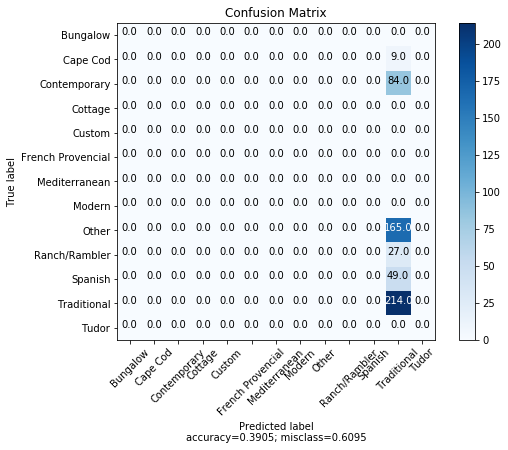

In [91]:
import matplotlib.pyplot as plt
plot_confusion_matrix(cm = confusion_matrix, 
                      normalize = False,
                      target_names = list_of_labels,
                      title = "Confusion Matrix")
plt.show()

In [7]:
# model with softmax as output activation layer
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(13, activation='softmax')(x)

transfer_model = tf.keras.models.Model(base_model.input, x)

transfer_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])


In [8]:
batch_size = 32

transfer_model.fit_generator(train_generator,
                             steps_per_epoch=1644 // batch_size,
                             epochs=5,
                             validation_data=valid_generator,
                             validation_steps= 548 // batch_size)

Epoch 1/5
51/51 [==============================] - 300s 6s/step - loss: 10.3478 - acc: 0.2909 - val_loss: 6.7466 - val_acc: 0.3695
Epoch 2/5
51/51 [==============================] - 280s 5s/step - loss: 4.1280 - acc: 0.2965 - val_loss: 4.5626 - val_acc: 0.3713
Epoch 3/5
51/51 [==============================] - 276s 5s/step - loss: 2.8019 - acc: 0.2922 - val_loss: 3.8988 - val_acc: 0.3713
Epoch 4/5
51/51 [==============================] - 273s 5s/step - loss: 2.3475 - acc: 0.3213 - val_loss: 3.0683 - val_acc: 0.3713
Epoch 5/5
51/51 [==============================] - 278s 5s/step - loss: 2.1836 - acc: 0.3108 - val_loss: 3.4291 - val_acc: 0.3511


In [9]:
transfer_model.save_weights('transfer_model.h5')

In [15]:
# serialize model to JSON
model_json = transfer_model.to_json()
with open("transfer_model.json", "w") as json_file:
    json_file.write(model_json)

In [10]:
test_features = transfer_model.predict_generator(test_generator, 548)
test_features

array([[6.33100281e-03, 1.02512666e-03, 2.21045077e-01, ...,
        1.98925845e-03, 3.39422256e-01, 2.96051032e-04],
       [2.23182118e-03, 1.00949772e-04, 2.78817952e-01, ...,
        2.46672222e-04, 4.55523878e-01, 4.97913243e-05],
       [3.57367191e-03, 4.57612972e-04, 2.42982090e-01, ...,
        9.66255087e-04, 3.76388639e-01, 2.05102086e-04],
       ...,
       [4.53943051e-02, 2.07489002e-02, 2.15882495e-01, ...,
        2.88400911e-02, 2.68609971e-01, 1.38701815e-02],
       [7.56435236e-03, 1.28097681e-03, 2.40543306e-01, ...,
        2.00616056e-03, 3.79822999e-01, 5.62003988e-04],
       [1.82046518e-02, 5.08476514e-03, 2.30447084e-01, ...,
        8.36991984e-03, 3.75868648e-01, 2.79849255e-03]], dtype=float32)

In [11]:
predicted_class_indices=np.argmax(test_features,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [12]:
true_labels = list(final.home_style)[train_validate_size:]
test_accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == true_labels[i]:
        test_accuracy += 1
test_accuracy = test_accuracy/len(true_labels)
test_accuracy

0.3704379562043796

In [138]:
predictions

['Other',
 'Contemporary',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Other',
 'Other',
 'Traditional',
 'Other',
 'Traditional',
 'Traditional',
 'Other',
 'Traditional',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Other',
 'Traditional',
 'Other',
 'Other',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Traditional',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Traditional',
 'Other',
 'Traditional',
 'Other',
 'Traditional',
 'Other',
 'Traditional',
 'Other',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Other',
 'Other',
 'Traditional',
 'Traditional',
 'Other',
 'Other',
 'Oth

In [13]:
# confusion matrix
confusion_matrix = np.zeros((13, 13))
list_of_labels = list(labels.values())
for k in range(len(predictions)):
    true_label, predicted_label = true_labels[k], predictions[k]
    true_idx = list_of_labels.index(true_label)
    predicted_idx = list_of_labels.index(predicted_label)
    confusion_matrix[true_idx, predicted_idx] += 1

In [14]:
confusion_matrix

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          9.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   0.,
         71.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,
        149.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         27.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 

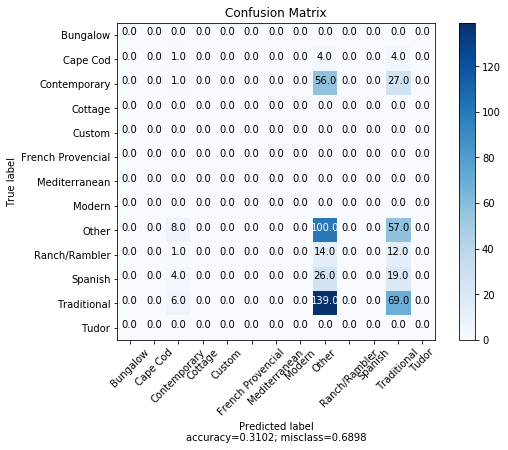

In [141]:
plot_confusion_matrix(cm = confusion_matrix, 
                      normalize = False,
                      target_names = list_of_labels,
                      title = "Confusion Matrix")
plt.show()

tips:
clustering, regularization, random forests
use mls images
data augmentation? datagen = ImageDataGenerator(horizontal flip=True)
batch normalization?

### Three major problems

1) imbalanced dataset

2) home_style feature from mls not accurate

3) the set of images of one listing id can be too distinct (indoor, outdoor), atypical

In [52]:
# extract features from the middle layers
from keras import Model

extract = Model(model2.inputs, model2.layers[-1].output) # Dense(128,...)
extract.predict_generator(test_generator, 548)

array([[0.06110674, 0.03514252, 0.23885754, ..., 0.04489372, 0.23768088,
        0.0251676 ],
       [0.07079681, 0.05010645, 0.17047784, ..., 0.05739021, 0.19196303,
        0.04114271],
       [0.07104078, 0.05012501, 0.17228974, ..., 0.05651642, 0.18882746,
        0.04143267],
       ...,
       [0.07066629, 0.04746737, 0.18170601, ..., 0.05327886, 0.20391138,
        0.03644801],
       [0.0667159 , 0.04568422, 0.20083989, ..., 0.05149116, 0.21057421,
        0.03199296],
       [0.06806982, 0.04695377, 0.18857972, ..., 0.05292043, 0.20230797,
        0.03601186]], dtype=float32)